In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import graphviz

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [3]:
df_total = pd.read_csv(r'/Users/ngohoanganh/Desktop/COVID19_VN_MOH_MLmodels/predict-LOS(length-of-stay)/assets/processed/df_total.csv', encoding="utf-8")
# remove patients 172, 173, 174 of df_total due to lack of information
df_total = df_total[~(df_total["PATIENT_NO"].isin([172, 173, 174]))]

df_train = pd.read_csv(r'/Users/ngohoanganh/Desktop/COVID19_VN_MOH_MLmodels/predict-LOS(length-of-stay)/assets/processed/df_train.csv', encoding="utf-8")

df_test = pd.read_csv(r'/Users/ngohoanganh/Desktop/COVID19_VN_MOH_MLmodels/predict-LOS(length-of-stay)/assets/processed/df_test.csv', encoding="utf-8")
# remove patients 172, 173, 174 of df_test due to lack of information
df_test = df_test[~(df_test["PATIENT_NO"].isin([172, 173, 174]))]

In [4]:
df_total.info()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 202
Data columns (total 18 columns):
PATIENT_NO            200 non-null int64
AGE                   200 non-null float64
SEX                   200 non-null int64
ORIGIN_EUROPE         200 non-null int64
ORIGIN_CHINA          200 non-null int64
ORIGIN_US             200 non-null int64
ORIGIN_ASEAN          200 non-null int64
ORIGIN_DOMESTIC       200 non-null int64
DAYS_OF_ONSET         200 non-null int64
ONSET_FEVER           200 non-null int64
ONSET_COUGH           200 non-null int64
ONSET_TIRED           200 non-null int64
ONSET_SORETHROAT      200 non-null int64
ONSET_RESPIRATORY     200 non-null int64
BACKGROUND_DISEASE    200 non-null int64
HOSPITAL              200 non-null int64
RISK_SCORE            200 non-null int64
LOS                   56 non-null float64
dtypes: float64(2), int64(16)
memory usage: 29.7 KB


,PATIENT_NO,AGE,SEX,ORIGIN_EUROPE,ORIGIN_CHINA,ORIGIN_US,ORIGIN_ASEAN,ORIGIN_DOMESTIC,DAYS_OF_ONSET,ONSET_FEVER,ONSET_COUGH,ONSET_TIRED,ONSET_SORETHROAT,ONSET_RESPIRATORY,BACKGROUND_DISEASE,HOSPITAL,RISK_SCORE,LOS
198,199,57.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
199,200,61.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
200,201,23.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
201,202,57.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
202,203,35.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN


In [5]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 18 columns):
PATIENT_NO            56 non-null int64
AGE                   56 non-null float64
SEX                   56 non-null int64
ORIGIN_EUROPE         56 non-null int64
ORIGIN_CHINA          56 non-null int64
ORIGIN_US             56 non-null int64
ORIGIN_ASEAN          56 non-null int64
ORIGIN_DOMESTIC       56 non-null int64
DAYS_OF_ONSET         56 non-null int64
ONSET_FEVER           56 non-null int64
ONSET_COUGH           56 non-null int64
ONSET_TIRED           56 non-null int64
ONSET_SORETHROAT      56 non-null int64
ONSET_RESPIRATORY     56 non-null int64
BACKGROUND_DISEASE    56 non-null int64
HOSPITAL              56 non-null int64
RISK_SCORE            56 non-null int64
LOS                   56 non-null int64
dtypes: float64(1), int64(17)
memory usage: 8.0 KB


,PATIENT_NO,AGE,SEX,ORIGIN_EUROPE,ORIGIN_CHINA,ORIGIN_US,ORIGIN_ASEAN,ORIGIN_DOMESTIC,DAYS_OF_ONSET,ONSET_FEVER,ONSET_COUGH,ONSET_TIRED,ONSET_SORETHROAT,ONSET_RESPIRATORY,BACKGROUND_DISEASE,HOSPITAL,RISK_SCORE,LOS
0,1,66.0,1,0,1,0,0,0,6,0,0,0,0,0,2,1,8,21
1,2,28.0,1,0,1,0,0,0,3,0,0,0,0,0,0,1,8,13
2,3,25.0,0,0,1,0,0,0,7,0,0,0,0,0,0,0,8,5
3,4,29.0,1,0,1,0,0,0,9,0,0,0,0,0,0,0,8,20
4,5,23.0,0,0,1,0,0,0,5,0,0,0,0,0,0,0,8,12


In [6]:
df_test.info()
df_test.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 146
Data columns (total 18 columns):
PATIENT_NO            144 non-null int64
AGE                   144 non-null float64
SEX                   144 non-null int64
ORIGIN_EUROPE         144 non-null int64
ORIGIN_CHINA          144 non-null int64
ORIGIN_US             144 non-null int64
ORIGIN_ASEAN          144 non-null int64
ORIGIN_DOMESTIC       144 non-null int64
DAYS_OF_ONSET         144 non-null int64
ONSET_FEVER           144 non-null int64
ONSET_COUGH           144 non-null int64
ONSET_TIRED           144 non-null int64
ONSET_SORETHROAT      144 non-null int64
ONSET_RESPIRATORY     144 non-null int64
BACKGROUND_DISEASE    144 non-null int64
HOSPITAL              144 non-null int64
RISK_SCORE            144 non-null int64
LOS                   0 non-null float64
dtypes: float64(2), int64(16)
memory usage: 21.4 KB


,PATIENT_NO,AGE,SEX,ORIGIN_EUROPE,ORIGIN_CHINA,ORIGIN_US,ORIGIN_ASEAN,ORIGIN_DOMESTIC,DAYS_OF_ONSET,ONSET_FEVER,ONSET_COUGH,ONSET_TIRED,ONSET_SORETHROAT,ONSET_RESPIRATORY,BACKGROUND_DISEASE,HOSPITAL,RISK_SCORE,LOS
142,199,57.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
143,200,61.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
144,201,23.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
145,202,57.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,7,NaN
146,203,35.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN


In [7]:
# target variable (LOS)
LOS = df_train['LOS'].values

# extract patient no to build a new dataset for comparision between models
PATIENT_NO_test = df_test['PATIENT_NO']

In [8]:
# split train set and test set (without y_test)
X_train = df_train.drop(columns = ['LOS', 'PATIENT_NO'])

y_train = LOS

X_test = df_test.drop(columns = ['LOS', 'PATIENT_NO'])

In [9]:
X_train.describe()


,AGE,SEX,ORIGIN_EUROPE,ORIGIN_CHINA,ORIGIN_US,ORIGIN_ASEAN,ORIGIN_DOMESTIC,DAYS_OF_ONSET,ONSET_FEVER,ONSET_COUGH,ONSET_TIRED,ONSET_SORETHROAT,ONSET_RESPIRATORY,BACKGROUND_DISEASE,HOSPITAL,RISK_SCORE
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,34.200893,0.464286,0.535714,0.160714,0.071429,0.0,0.214286,2.214286,0.178571,0.142857,0.053571,0.035714,0.035714,0.071429,0.107143,4.428571
std,15.989657,0.503236,0.503236,0.370591,0.259870,0.0,0.414039,2.852204,0.386459,0.353094,0.227208,0.187256,0.187256,0.322329,0.312094,1.915080
min,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,29.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,44.250000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,73.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,8.000000


In [10]:
X_test.describe()

,AGE,SEX,ORIGIN_EUROPE,ORIGIN_CHINA,ORIGIN_US,ORIGIN_ASEAN,ORIGIN_DOMESTIC,DAYS_OF_ONSET,ONSET_FEVER,ONSET_COUGH,ONSET_TIRED,ONSET_SORETHROAT,ONSET_RESPIRATORY,BACKGROUND_DISEASE,HOSPITAL,RISK_SCORE
count,144.000000,144.000000,144.000000,144.0,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,36.111111,0.444444,0.472222,0.0,0.041667,0.083333,0.381944,0.868056,0.180556,0.131944,0.013889,0.069444,0.034722,0.034722,0.298611,3.770833
std,16.381002,0.498638,0.500970,0.0,0.200524,0.277350,0.487559,1.986833,0.385992,0.339612,0.117438,0.255096,0.183714,0.183714,0.459246,1.876311
min,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,23.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,33.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,49.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000
max,88.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [11]:
GB_models = [GradientBoostingRegressor(random_state = 0)]

results = [PATIENT_NO_test]

for model in GB_models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    results.append(y_test_preds)
    
    # Grab model name and store results associated with model
    # impossible to calculate r2 score dude to lack of y_test
    name = str(model).split("(")[0]
    print('{} finished.'.format(name))

GradientBoostingRegressor finished.


In [12]:
df_results = pd.DataFrame(np.transpose(results))

df_results = df_results.rename(columns={0 : "PATIENT_NO", 
                                        1 : "LOS_GradientBoostingRegressor"})

df_results

,PATIENT_NO,LOS_GradientBoostingRegressor
0,19.0,16.899319
1,20.0,23.455169
2,25.0,21.023090
3,26.0,20.845830
4,28.0,24.445380
5,30.0,17.381470
6,31.0,17.383201
7,32.0,4.617170
8,34.0,21.582450
9,36.0,20.739080


## Extreme Gradient Boosting Regressor

In [13]:
xgb.XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [14]:
reg_model_XGB = xgb.XGBRegressor()

reg_model_XGB.fit(X_train, y_train)

y_test_preds_XGB = reg_model_XGB.predict(X_test)

df_results['LOS_XGBRegressor'] = y_test_preds_XGB

[17:45:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
df_results

,PATIENT_NO,LOS_GradientBoostingRegressor,LOS_XGBRegressor
0,19.0,16.899319,18.068926
1,20.0,23.455169,23.454885
2,25.0,21.023090,23.139446
3,26.0,20.845830,21.574360
4,28.0,24.445380,22.270910
5,30.0,17.381470,18.072773
6,31.0,17.383201,15.965472
7,32.0,4.617170,9.727282
8,34.0,21.582450,19.750154
9,36.0,20.739080,19.171511


In [16]:
df_results.to_csv(r'./GB_models_untuned.csv', index = False)

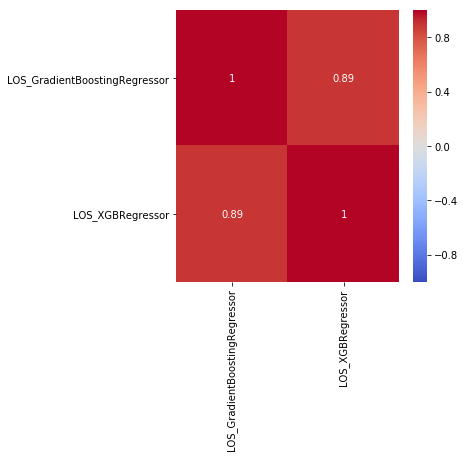

In [17]:
corr_matrix_untuned_results = df_results.drop(columns = ['PATIENT_NO']).corr()

plt.figure(figsize=(5,5))
fig = sns.heatmap(corr_matrix_untuned_results,
            vmin=-1,
            cmap='coolwarm',
            annot=True)
fig.figure.savefig('./corr_matrix_untuned_results(GBR+XGBR).png', bbox_inches = 'tight')

## Parameter tuning for Gradient Boosting Regressor

In [18]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [20]:
tuned_parameters_GBR = [{'learning_rate': np.linspace(0.05, 0.5, 10, endpoint = True),
                         'n_estimators': [100, 200, 300, 400, 500],
                         'max_depth' : [3, 4],
                         'loss': ['ls', 'lad', 'huber']}]

# create and fit a ridge regression model, testing each alpha
reg_model_GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(reg_model_GBR, tuned_parameters_GBR)
grid_GBR.fit(X_train, y_train)
reg_model_GBR_optimized = grid_GBR.best_estimator_

# summarize the results of the grid search
print(grid_GBR.best_score_)
print(grid_GBR.best_estimator_)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.9225931798377679
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15000000000000002, loss='lad', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [21]:
# obtain new prediction results and replace into the result dataset
y_test_preds_GBR = reg_model_GBR_optimized.predict(X_test)

df_results['LOS_GradientBoostingRegressor'] = y_test_preds_GBR

In [22]:
# calculate feature importance
feature_imp_GBR = pd.DataFrame(reg_model_GBR_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['Feature importance (GB Regressor)']).sort_values('Feature importance (GB Regressor)', ascending=False)

feature_imp_GBR

,Feature importance (GB Regressor)
AGE,0.412011
DAYS_OF_ONSET,0.178663
BACKGROUND_DISEASE,0.090674
RISK_SCORE,0.078745
ONSET_SORETHROAT,0.069661
SEX,0.053585
HOSPITAL,0.023869
ORIGIN_DOMESTIC,0.023316
ONSET_TIRED,0.017516
ORIGIN_US,0.014332


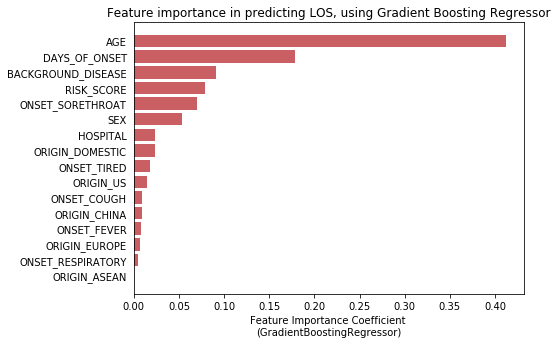

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,16)
ax.barh(ind, feature_imp_GBR['Feature importance (GB Regressor)'].values[0:16], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp_GBR.index[0:16].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Feature importance in predicting LOS, using Gradient Boosting Regressor")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('./feature_importance_GBRegresor.png', bbox_inches = 'tight')

## Parameter tuning for Extreme Gradient Boosting Regressor

In [24]:
xgb.XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [25]:
tuned_parameters_XGBR = [{'learning_rate': np.linspace(0.05, 0.5, 10, endpoint = True),
                           'n_estimators': [100, 200, 300, 400, 500],
                           'max_depth' : [3, 4, 5]}]

# create and fit a ridge regression model, testing each alpha
reg_model_XGBR = xgb.XGBRegressor()
grid_XGBR = GridSearchCV(reg_model_XGBR, tuned_parameters_XGBR, cv = 5)
grid_XGBR.fit(X_train, y_train)
reg_model_XGBR_optimized = grid_XGBR.best_estimator_

# summarize the results of the grid search
print(grid_XGBR.best_score_)
print(grid_XGBR.best_estimator_)

[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:06:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
scores_XGBR = cross_val_score(reg_model_XGBR, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores_XGBR.mean())

kfold_XGBR = KFold(n_splits=10, shuffle=True)
kf_cv_scores_XGBR = cross_val_score(reg_model_XGBR, X_train, y_train, cv= kfold_XGBR)
print("K-fold CV average score: %.2f" % kf_cv_scores_XGBR.mean())

[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score: -1.88
[18:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:12] WARNING: src/objective/reg

In [29]:
y_test_preds_XGBR = reg_model_XGBR_optimized.predict(X_test)

df_results['LOS_XGBRegressor'] = y_test_preds_XGBR

In [30]:
feature_imp_XGBR = pd.DataFrame(reg_model_XGBR_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['Feature importance (XGB Regressor)']).sort_values('Feature importance (XGB Regressor)', ascending=False)

feature_imp_XGBR

,Feature importance (XGB Regressor)
ONSET_TIRED,0.123153
ONSET_FEVER,0.112541
DAYS_OF_ONSET,0.106976
ONSET_COUGH,0.102950
ORIGIN_CHINA,0.084449
AGE,0.081394
RISK_SCORE,0.078345
SEX,0.066298
HOSPITAL,0.065378
ORIGIN_DOMESTIC,0.057259


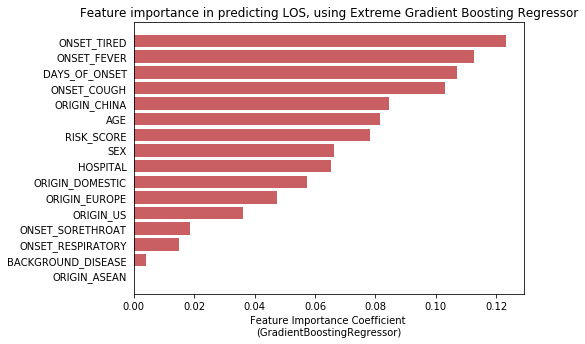

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,16)
ax.barh(ind, feature_imp_XGBR['Feature importance (XGB Regressor)'].values[0:16], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp_XGBR.index[0:16].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Feature importance in predicting LOS, using Extreme Gradient Boosting Regressor")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('./feature_importance_XGBRegresor.png', bbox_inches = 'tight')

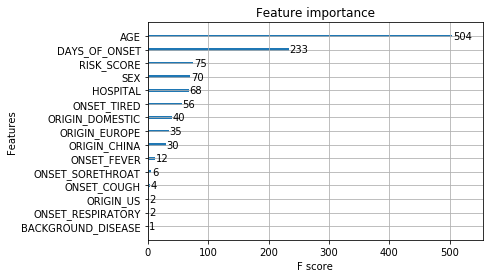

In [32]:
fig = xgb.plot_importance(reg_model_XGBR_optimized)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
fig.figure.savefig('./feature_importance_XGBRegresor_Fscore.png', bbox_inches = 'tight')

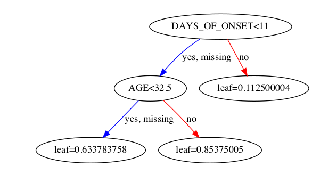

In [33]:
xgb.plot_tree(reg_model_XGBR_optimized,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [34]:
df_results

,PATIENT_NO,LOS_GradientBoostingRegressor,LOS_XGBRegressor
0,19.0,17.647415,16.952238
1,20.0,19.785068,21.362158
2,25.0,21.694947,20.580730
3,26.0,20.240115,20.331102
4,28.0,20.895548,20.367292
5,30.0,16.716436,17.801939
6,31.0,13.073325,18.339634
7,32.0,10.492083,9.553496
8,34.0,15.928111,20.521618
9,36.0,15.723832,16.894445


In [35]:
df_results.to_csv(r'./GB_models_tuned.csv', index = False)

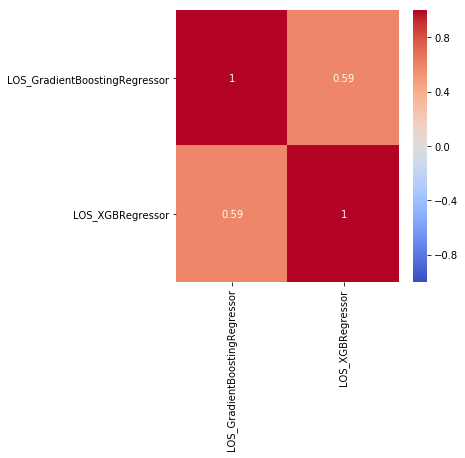

In [36]:
corr_matrix_tuned_results = df_results.drop(columns = ['PATIENT_NO']).corr()

plt.figure(figsize=(5,5))
fig = sns.heatmap(corr_matrix_tuned_results,
            vmin=-1,
            cmap='coolwarm',
            annot=True)
fig.figure.savefig('./corr_matrix_tuned_results(GBR+XGBR).png', bbox_inches = 'tight')